# Bayesian Optimization
### Sequential Model Based Optimization using the Tree Parzen Estimator

There are four parts to an optimization problem:

1. Objective function: what we want to minimize
2. Domain space: values of the parameters over which to minimize the objective
3. Hyperparameter optimization function: constructs the surrogate function and chooses next values to evaluate
4. Trials: score, parameter pairs recorded each time we evaluate the objective function

Evaluating the objective function is the expensive part of optimization, so ideally we want to limit calls to this function. One way we can limit calls is by choosing the next values to try in the objective function based on the past results. Bayesian optimization differs from random or grid search by doing exactly this: rather than just selecting from a grid uninformed by past objective function evaluations, Bayesian methods take into account the previous results to try more promising values. They work by constructing a probability model of the objective function (called a surrogate function) p(score|parameters)  which is much easier to optimize than the actual objective function.



In [2]:
# Good old pandas and numpy
import pandas as pd
import numpy as np

# Unfortunately I'm still using matplotlib for graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Objective function

Here we define a simple polynomial objective function and the goal is to find the minimum of this function. This model have a global and a local minima. In our case the loss function of the TME model is the objective


In [3]:

def objective(x):
    """Objective function to minimize"""
    
    # Create the polynomial object
    f = np.poly1d([1, -2, -28, 28, 12, -26, 100])

    # Return the value of the polynomial
    return f(x) * 0.05

Minimum of -219.8012 occurs at 4.8779


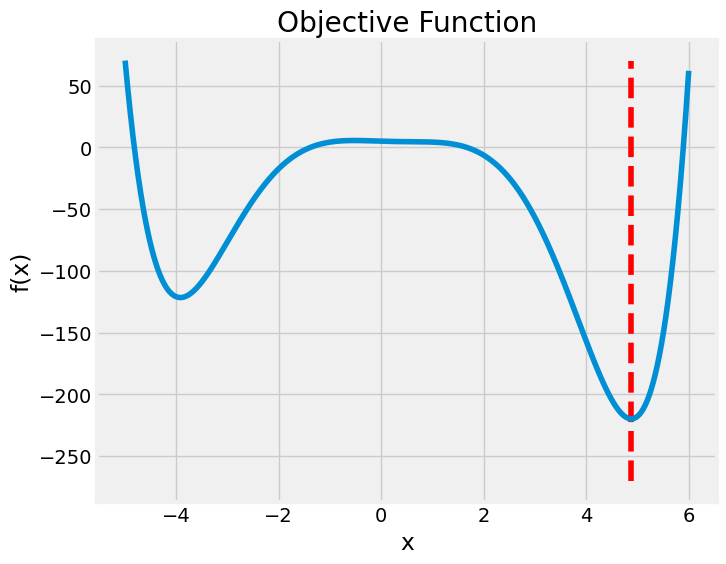

In [4]:
# Space over which to evluate the function is -5 to 6
x = np.linspace(-5, 6, 10000)
y = objective(x)

miny = min(y)
minx = x[np.argmin(y)]

# Visualize the function
plt.figure(figsize = (8, 6))
plt.style.use('fivethirtyeight')
plt.title('Objective Function'); plt.xlabel('x'); plt.ylabel('f(x)')
plt.vlines(minx, min(y)- 50, max(y), linestyles = '--', colors = 'r')
plt.plot(x, y);

# Print out the minimum of the function and value
print('Minimum of %0.4f occurs at %0.4f' % (miny, minx))

# Domain

The domain is the values of the x over which we evaluate the function. First we can use a uniform distribution over the space our function is defined.

In [6]:
from hyperopt import hp

# Create the domain space
space = hp.uniform('x', -5, 6)

So if we draw random smaple from a uniform distribution . The histogram of the vaklues that we drew are shown below:

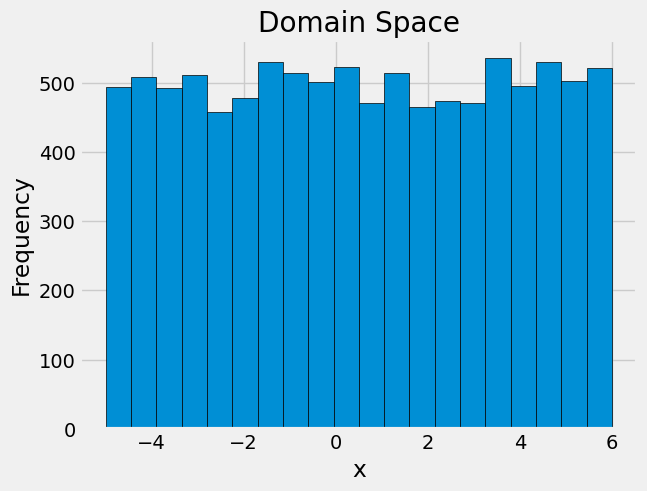

In [7]:
from hyperopt.pyll.stochastic import sample


samples = []

# Sample 10000 values from the range
for _ in range(10000):
    samples.append(sample(space))
    

# Histogram of the values
plt.hist(samples, bins = 20, edgecolor = 'black'); 
plt.xlabel('x'); plt.ylabel('Frequency'); plt.title('Domain Space');

# Hyperparameter Optimization Algorithm
Random and Tree Parzen Estimator are two choices for hyperparameters optimization algorithm 

In [8]:
from hyperopt import rand, tpe

# Create the algorithms
tpe_algo = tpe.suggest
rand_algo = rand.suggest

## History 

Storing the history of the optimization

In [9]:
from hyperopt import Trials

# Create two trials objects
tpe_trials = Trials()
rand_trials = Trials()

# Run the Optimization

In [10]:
from hyperopt import fmin

# Run 2000 evals with the tpe algorithm
tpe_best = fmin(fn=objective, space=space, algo=tpe_algo, trials=tpe_trials, 
                max_evals=2000, rstate= np.random.default_rng(50))

print(tpe_best)

# Run 2000 evals with the random algorithm
rand_best = fmin(fn=objective, space=space, algo=rand_algo, trials=rand_trials, 
                 max_evals=2000, rstate= np.random.default_rng(50))

100%|██████████| 2000/2000 [00:14<00:00, 140.69trial/s, best loss: -219.80099175991256]
{'x': 4.876852885822449}
100%|██████████| 2000/2000 [00:04<00:00, 498.40trial/s, best loss: -219.80075470018747]


In [11]:
# Print out information about losses
print('Minimum loss attained with TPE:    {:.4f}'.format(tpe_trials.best_trial['result']['loss']))
print('Minimum loss attained with random: {:.4f}'.format(rand_trials.best_trial['result']['loss']))
print('Actual minimum of f(x):            {:.4f}'.format(miny))

# Print out information about number of trials
print('\nNumber of trials needed to attain minimum with TPE:    {}'.format(tpe_trials.best_trial['misc']['idxs']['x'][0]))
print('Number of trials needed to attain minimum with random: {}'.format(rand_trials.best_trial['misc']['idxs']['x'][0]))

# Print out information about value of x
print('\nBest value of x from TPE:    {:.4f}'.format(tpe_best['x']))
print('Best value of x from random: {:.4f}'.format(rand_best['x']))
print('Actual best value of x:      {:.4f}'.format(minx))

Minimum loss attained with TPE:    -219.8010
Minimum loss attained with random: -219.8008
Actual minimum of f(x):            -219.8012

Number of trials needed to attain minimum with TPE:    1025
Number of trials needed to attain minimum with random: 1124

Best value of x from TPE:    4.8769
Best value of x from random: 4.8763
Actual best value of x:      4.8779


In [12]:
%%timeit -n 3
# Run 2000 evals with the tpe algorithm
best = fmin(fn=objective, space=space, algo=tpe_algo, max_evals=200)

100%|██████████| 200/200 [00:00<00:00, 446.14trial/s, best loss: -219.796099730293] 
460 ms ± 19.5 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [13]:
%%timeit -n 3

# Run 2000 evals with the random algorithm
best = fmin(fn=objective, space=space, algo=tpe_algo, max_evals=200)

100%|██████████| 200/200 [00:00<00:00, 448.67trial/s, best loss: -219.80109851289805]
459 ms ± 17.1 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


# Results

To see how they differ in the search preocedure, we can take a look at the trials objects.

In [19]:
tpe_results = pd.DataFrame({'loss': [x['loss'] for x in tpe_trials.results], 'iteration': tpe_trials.idxs_vals[0]['x'],
                            'x': tpe_trials.idxs_vals[1]['x']})
                            
tpe_results.head()

,loss,iteration,x
0,4.243222,0,1.003951
1,-57.738513,1,3.009983
2,-150.326644,2,3.938818
3,-49.041084,3,-2.603459
4,4.567382,4,5.902121


In [26]:
tpe_results['rolling_average_x'] = tpe_results['x'].rolling(50).mean().fillna(method = 'bfill')
tpe_results['rolling_average_loss'] = tpe_results['loss'].rolling(50).mean().fillna(method = 'bfill')
tpe_results.head()

,loss,iteration,x,rolling_average_x,rolling_average_loss
0,4.243222,0,1.003951,1.831681,-73.491736
1,-57.738513,1,3.009983,1.831681,-73.491736
2,-150.326644,2,3.938818,1.831681,-73.491736
3,-49.041084,3,-2.603459,1.831681,-73.491736
4,4.567382,4,5.902121,1.831681,-73.491736


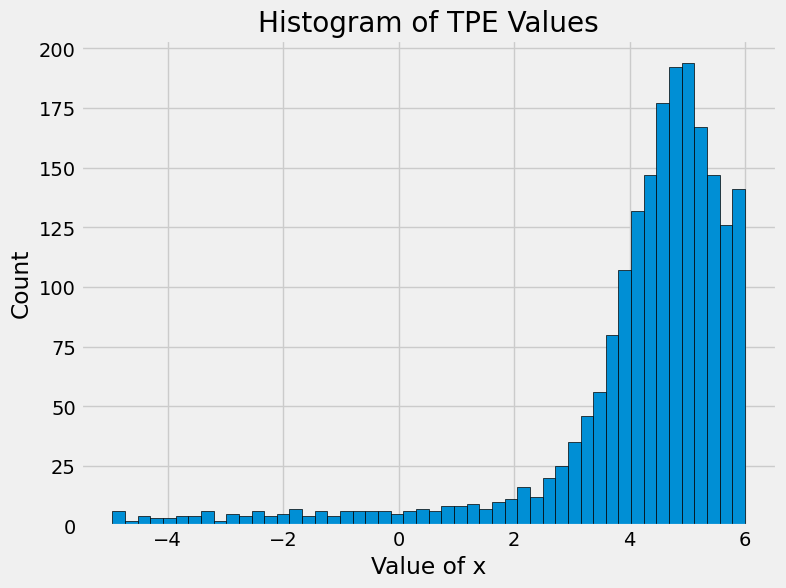

In [27]:
plt.figure(figsize = (8, 6))
plt.hist(tpe_results['x'], bins = 50, edgecolor = 'k');
plt.title('Histogram of TPE Values'); plt.xlabel('Value of x'); plt.ylabel('Count');

In [28]:
rand_results = pd.DataFrame({'loss': [x['loss'] for x in rand_trials.results], 'iteration': rand_trials.idxs_vals[0]['x'],
                            'x': rand_trials.idxs_vals[1]['x']})
                            
rand_results.head()

,loss,iteration,x
0,4.243222,0,1.003951
1,-57.738513,1,3.009983
2,-150.326644,2,3.938818
3,-49.041084,3,-2.603459
4,4.567382,4,5.902121


Best Loss of -219.8008 occured at iteration 1124


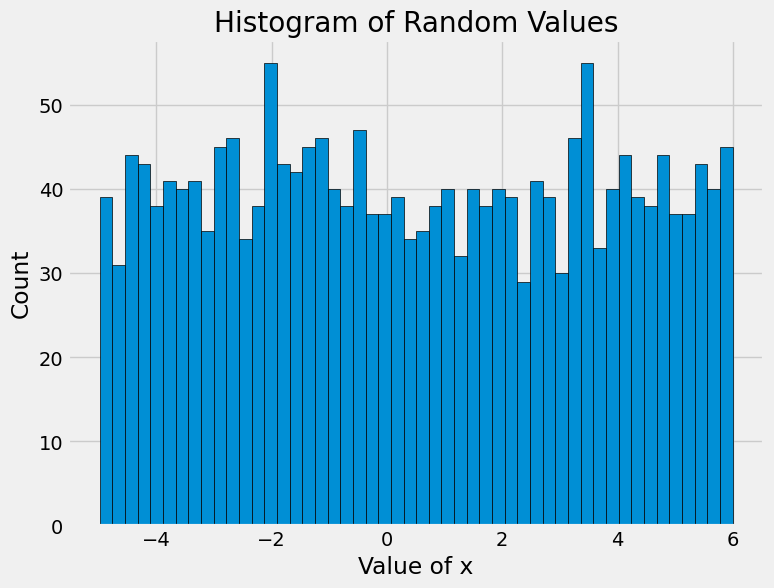

In [29]:
# Sort with best loss first
rand_results = rand_results.sort_values('loss', ascending = True).reset_index()

plt.figure(figsize = (8, 6))
plt.hist(rand_results['x'], bins = 50, edgecolor = 'k');
plt.title('Histogram of Random Values'); plt.xlabel('Value of x'); plt.ylabel('Count');

# Print information
print('Best Loss of {:.4f} occured at iteration {}'.format(rand_results['loss'][0], rand_results['iteration'][0]))

# Slightly Advanced Concepts
## Better Domain Space

In this problem, we can cheat because we know where the minimum is and therefore can define a region of higher probability around this value of x. In more complicated problems, we don't have a graph to show us the minimum, but we can still use experience and knowledge to inform our choice of a domain space.

Here we will make a normally distributed domain space around the value where the minimum of the objective function occurs, around 4.9. This is simple to do in Hyperopt.



In [30]:
# Normally distributed space
space = hp.normal('x', 4.9, 0.5)

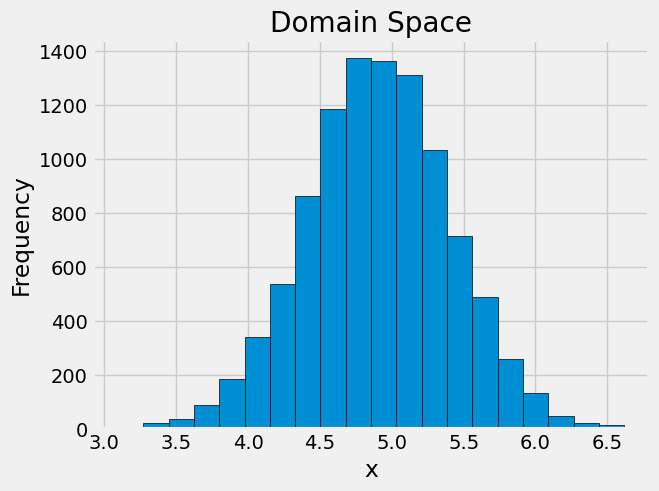

In [31]:
samples = []

# Sample 10000 values from the range
for _ in range(10000):
    samples.append(sample(space))
    

# Histogram of the values
plt.hist(samples, bins = 20, edgecolor = 'black'); 
plt.xlabel('x'); plt.ylabel('Frequency'); plt.title('Domain Space');

## More Useful Trial Object

Another modification to make is to return more useful information from the objective function. We do this using a dictionary with any information we want included. The only requirements are that the dictionary must contain a single real-valued metric to minimize stored under a "loss" key and whether the function sucessfully ran, stored under a "status" key. Here we make the modifications to the objective to store the value of x as well as the time to evaluate.

In [33]:
from hyperopt import STATUS_OK
from timeit import default_timer as timer

In [34]:
def objective(x):
    """Objective function to minimize with smarter return values"""
    
    # Create the polynomial object
    f = np.poly1d([1, -2, -28, 28, 12, -26, 100])

    # Evaluate the function
    start = timer()
    loss = f(x) * 0.05
    end = timer()
    
    # Calculate time to evaluate
    time_elapsed = end - start
    
    results = {'loss': loss, 'status': STATUS_OK, 'x': x, 'time': time_elapsed}
    
    # Return dictionary
    return results

In [36]:
# New trials object
trials = Trials()

# Run 2000 evals with the tpe algorithm
best = fmin(fn=objective, space=space, algo=tpe_algo, trials=trials, 
                max_evals=2000, rstate= np.random.default_rng(120))

100%|██████████| 2000/2000 [00:13<00:00, 143.48trial/s, best loss: -219.80120383647179]


In [37]:
results = trials.results
results[:2]

[{'loss': -210.6074058278915,
  'status': 'ok',
  'x': 4.591506813883544,
  'time': 9.834591764956713e-05},
 {'loss': -215.84398050311233,
  'status': 'ok',
  'x': 4.695102328435256,
  'time': 9.273597970604897e-05}]

In [38]:
# Results into a dataframe
results_df = pd.DataFrame({'time': [x['time'] for x in results], 
                           'loss': [x['loss'] for x in results],
                           'x': [x['x'] for x in results],
                            'iteration': list(range(len(results)))})

# Sort with lowest loss on top
results_df = results_df.sort_values('loss', ascending = True)
results_df.head()

,time,loss,x,iteration
243,0.000045,-219.801204,4.878168,243
731,0.000041,-219.801203,4.878215,731
1032,0.000030,-219.801203,4.878037,1032
1279,0.000027,-219.801200,4.877950,1279
614,0.000046,-219.801199,4.877939,614


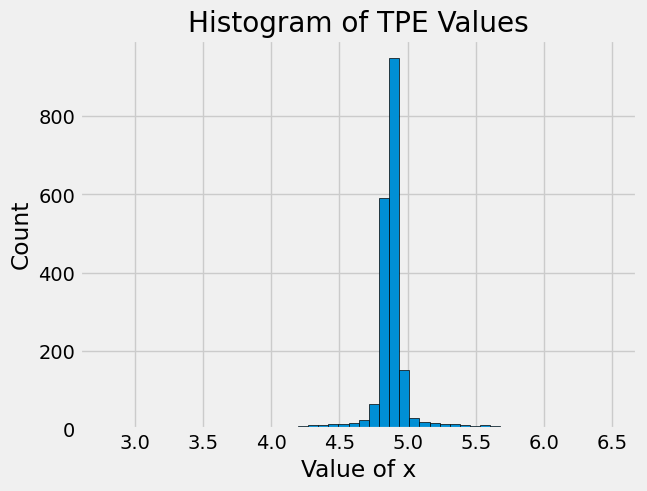

In [39]:
plt.hist(results_df['x'], bins = 50, edgecolor = 'k');
plt.title('Histogram of TPE Values'); plt.xlabel('Value of x'); plt.ylabel('Count');

# New example